# Customize your Processing Pipeline

This example can be referenced by [citing the package](https://neuropsychology.github.io/NeuroKit/cite_us.html).

While *NeuroKit* is designed to be beginner-friendly, experts who desire to have more control over their own processing pipeline are also offered the possibility to tune functions to their specific usage. This example shows how to use NeuroKit to customize your own processing pipeline for advanced users taking ECG processing as an example.

In [1]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd

In [ ]:
# Note: this cell is hidden using the "remove-input" tag
# Make bigger images
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]  
plt.rcParams['font.size']= 14

## The Default NeuroKit processing pipeline

*NeuroKit* provides a very useful set of functions, `*_process()` (e.g. `ecg_process()`, `eda_process()`, `emg_process()`, ...), which are all-in-one functions that cleans, preprocesses and processes the signals. It includes good and sensible defaults that should be suited for most of users and typical use-cases. That being said, in some cases, you might want to have more control over the processing pipeline.

This is how `ecg_process()` is typically used:

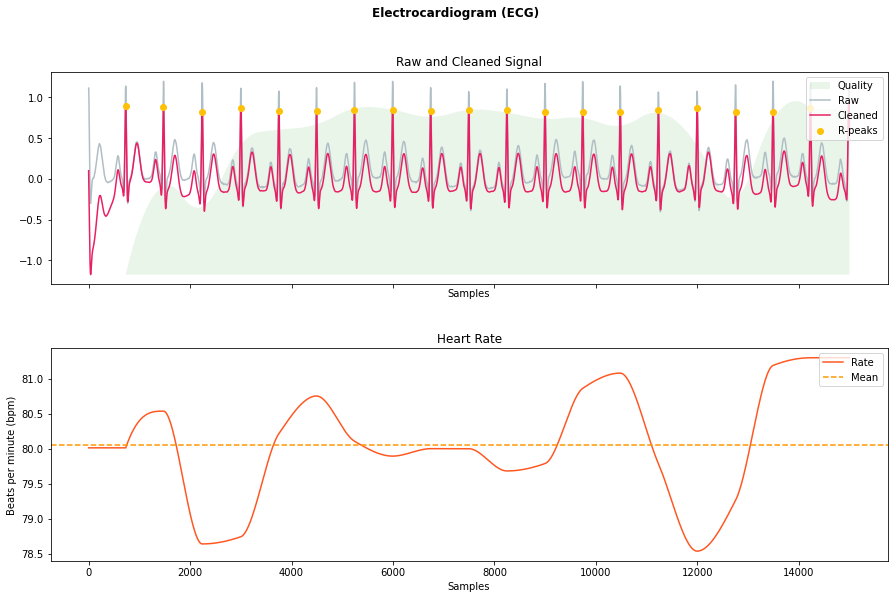

In [3]:
# Simulate ecg signal (you can use your own one)
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)

# Default processing pipeline
signals, info = nk.ecg_process(ecg, sampling_rate=1000)

# Visualize
nk.ecg_plot(signals)

## Building your own `process()` function

Now, if you look at the code of [`ecg_process()`](https://github.com/neuropsychology/NeuroKit/blob/master/neurokit2/ecg/ecg_process.py#L49) (see [here](https://neuropsychology.github.io/NeuroKit/resources/contributing.html#understanding-neurokit) for how to explore the code), you can see that it is in fact very simple.

It uses what can be referred to as "mid-level functions", such as `ecg_clean()`, `ecg_peaks()`, `ecg_rate()` etc.

This means that you can basically **re-create** the `ecg_process()` function very easily by calling these mid-level functions:

In [4]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000)
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    
    return signals, info

You can now use this function as you would do with `ecg_process()`.

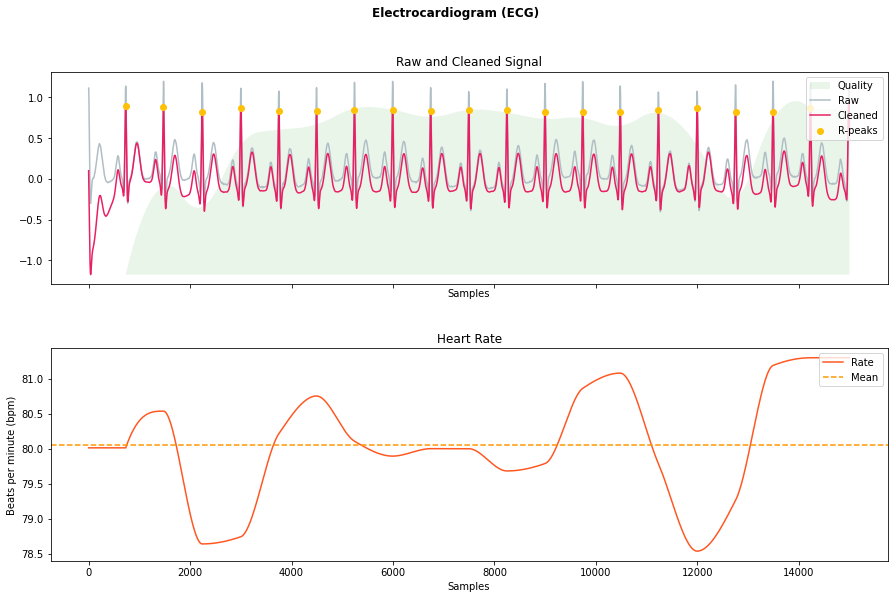

In [5]:
# Process the signal using previously defined function
signals, info = my_processing(ecg)

# Visualize
nk.ecg_plot(signals)

## Changing the processing parameters

Now, you might want to ask, why would you re-create the processing function? Well, it allows you to **change the parameters** of the inside as you please. Let's say you want to use a specific **cleaning** method.

First, let's look at the documentation for [`ecg_clean()`](https://neuropsychology.github.io/NeuroKit/functions/ecg.html#ecg-clean), you can see that they are several different methods for cleaning which can be specified. The default is the **NeuroKit** method, however depending on the quality of your signal (and several other factors), other methods may be more appropriate. It is up to you to make this decision.

You can now change the methods as you please for each function in your custom processing function that you have written above:

In [6]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=1000, method="engzeemod2012")
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    
    return signals, info

Similarly, you can select a different method for the peak detection.

## Customize even more!

It is possible that none of these methods suit your needs, or that you want to test a new method. Rejoice yourself, as *NeuroKit* allows you to do that by providing what can be referred to as "low-level" functions. 

For instance, you can rewrite the **cleaning** procedure by using the [signal processing tools](https://neuropsychology.github.io/NeuroKit/functions/signal.html) offered by *NeuroKit*:

In [7]:
def my_cleaning(ecg_signal, sampling_rate):
    detrended = nk.signal_detrend(ecg_signal, order=1)
    cleaned = nk.signal_filter(detrended, 
                               sampling_rate=sampling_rate, 
                               lowcut=2, 
                               highcut=9, 
                               method='butterworth')
    return cleaned

You can use this function inside your custom processing written above:

In [8]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = my_cleaning(ecg_signal, sampling_rate=1000)
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})

    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    
    return signals, info

Congrats, you have created your own processing pipeline! Let's see how it performs:

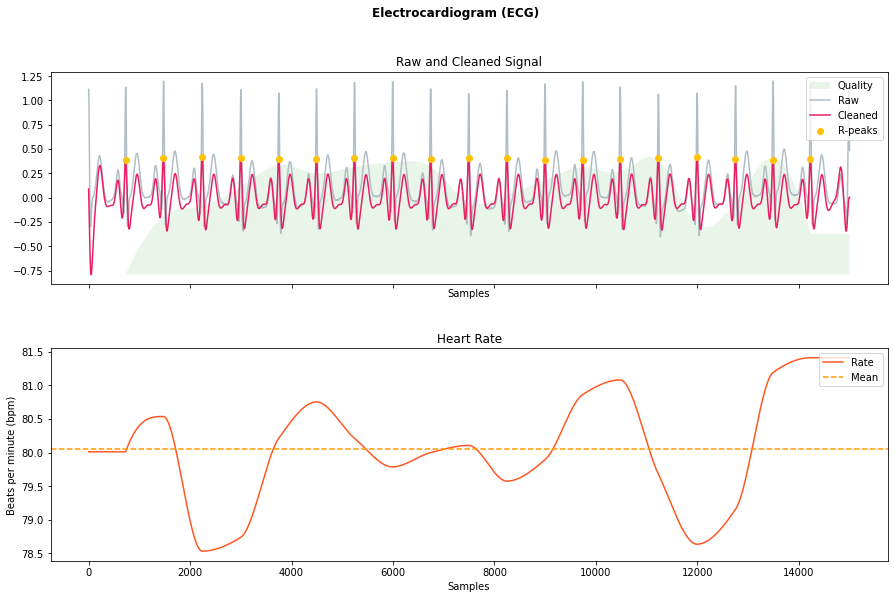

In [9]:
signals, info = my_processing(ecg)
nk.ecg_plot(signals)

This doesn't look bad :) **Can you do better?**